In [1]:
from netCDF4 import Dataset
from parcels import plotTrajectoriesFile,ParticleSet,JITParticle,FieldSet,Field
import numpy as np
from matplotlib import colors
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from datetime import datetime, timedelta
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import LogFormatter,LogLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib

In [2]:
def AreaCalc(sizeLat,sizeLon): #Calculate surface area of grid cells
    deg2rd = np.pi/180.
    r=6378.1
    lon_bins = np.linspace(0,360., sizeLon+1)
    lat_bins = np.linspace(-80, 80, sizeLat+1) 
    Area=np.array([[deg2rd*(lon_bins[i+1]-lon_bins[i])*(np.sin(deg2rd*lat_bins[j+1])
                            - np.sin(deg2rd*lat_bins[j])) for i in range(len(lon_bins)-1)] 
                            for j in range(len(lat_bins)-1)])
    Area=r*r*Area*1000*1000 #convert it to m^2 instead of km^2
    return Area

In [6]:
def AreaWeighAverage(dataset,coarseness):
    AreaInitial=AreaCalc(dataset.shape[0],dataset.shape[1])
    AreaFinal=AreaCalc(dataset.shape[0]/coarseness,dataset.shape[1]/coarseness)
    dataset[np.isnan(dataset)]=0
    DataSetArea=np.multiply(AreaInitial,dataset)
    temp=DataSetArea.reshape((DataSetArea.shape[0] // coarseness,coarseness,
                              DataSetArea.shape[1] // coarseness,coarseness))
    finalDataset = np.sum(temp,axis=(1,3))
    finalDataset=np.divide(finalDataset,AreaFinal)
    finalDataset[finalDataset==0]=np.nan
    return finalDataset 

In [7]:
def plotDensity(typ,lon,lat,dens):
    Lat,Lon=np.meshgrid(lat,lon)
    latmin,latmax=-90,90
    lonmin,lonmax=-180,180
    my_map = Basemap(projection='cyl', llcrnrlon=lonmin, 
                      urcrnrlon=lonmax,llcrnrlat=latmin,urcrnrlat=latmax, 
                      resolution='l')
    #my_map.drawcoastlines()
    #my_map.fillcontinents(color = 'gray')
    my_map.drawmapboundary()
    #my_map.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,1],fontsize=11)
    #my_map.drawparallels(np.arange(-90, 91, 30),labels=[1,0,0,0],fontsize=11)
    density=my_map.contourf(Lon,Lat,dens/1e-9,np.linspace(1e-1,2e0,20),
                              #norm=colors.LogNorm(1e-10,1e-9),
                              cmap='rainbow',extend='both')
    #my_map.contour(Lon,Lat,dens/1e-9,[2e0])
    title=['(a) NWD','(b) NWD + Stokes Drift','(c) NWD + Stokes Drift + WDE (Constant)','(d) NWD + Stokes Drift + WDE (M-Y 2.5)']
    plt.title(title[typ],fontsize=11,fontweight='bold')    
    return density

/Users/jakecunningham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


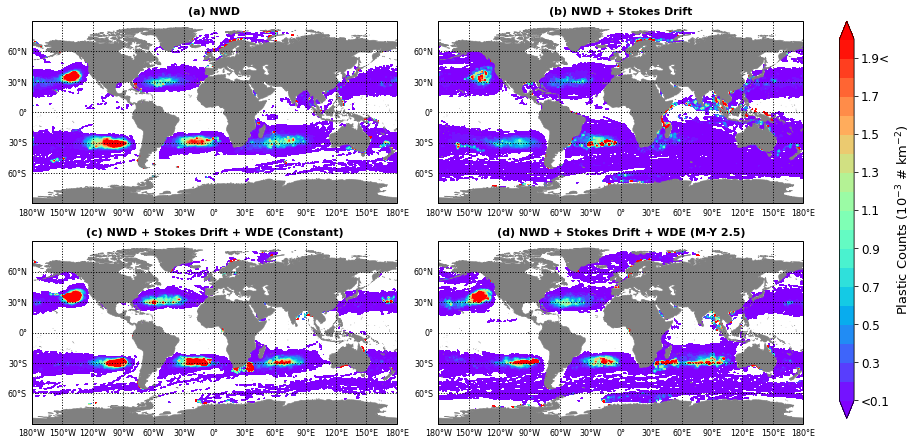

In [8]:
latD=np.linspace(-80,80,160)
lonD=np.linspace(-180,180,360)

fig = plt.figure(figsize=(12,12))

matplotlib.rc('font', size=8)
matplotlib.rc('axes', titlesize=11)

ax = plt.subplot(421,projection=ccrs.PlateCarree())
density=np.load('/Volumes/4YP/Data/Densities/Density_5Years_Global_Total.npy', allow_pickle=True)
density[np.isnan(density)]=0
meanFinalYear=np.sum(density[-183:,:,:]/density[-183:,:,:].shape[0],axis=0)#np.mean(density[-365:,:,:],axis=0)
meanFinalYear[meanFinalYear==0]=np.nan
#ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face',linewidth=0.5, facecolor='gray'))
density=plotDensity(0,lonD,latD,meanFinalYear)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.subplots_adjust(wspace=0.2)


ax = plt.subplot(422,projection=ccrs.PlateCarree())
density=np.load('/Volumes/4YP/Data/Densities/Density_5Years_Global_Total_Stokes.npy', allow_pickle=True)
density[np.isnan(density)]=0
meanFinalYear=np.sum(density[-183:,:,:]/density[-183:,:,:].shape[0],axis=0)#np.mean(density[-365:,:,:],axis=0)
meanFinalYear[meanFinalYear==0]=np.nan
#ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face',linewidth=0.5, facecolor='gray'))
density=plotDensity(1,lonD,latD,meanFinalYear)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.subplots_adjust(wspace=0.2)

ax = plt.subplot(423,projection=ccrs.PlateCarree())
density=np.load('/Volumes/4YP/Data/Densities/Density_5Years_Global_Total_Stokes_Eulerian.npy', allow_pickle=True)
density[np.isnan(density)]=0
meanFinalYear=np.sum(density[-183:,:,:]/density[-183:,:,:].shape[0],axis=0)#np.mean(density[-365:,:,:],axis=0)
meanFinalYear[meanFinalYear==0]=np.nan
#ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face',linewidth=0.5, facecolor='gray'))
density=plotDensity(2,lonD,latD,meanFinalYear)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.subplots_adjust(wspace=0.2)

ax = plt.subplot(424,projection=ccrs.PlateCarree())
density=np.load('/Volumes/4YP/Data/Densities/Density_5Years_Global_Total_Stokes_Eulerian_NEW.npy', allow_pickle=True)
density[np.isnan(density)]=0
meanFinalYear=np.sum(density[-183:,:,:]/density[-183:,:,:].shape[0],axis=0)#np.mean(density[-365:,:,:],axis=0)
meanFinalYear[meanFinalYear==0]=np.nan
#ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face',linewidth=0.5, facecolor='gray'))
density=plotDensity(3,lonD,latD,meanFinalYear)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.subplots_adjust(wspace=0.2)

fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)

fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.96, 0.52, 0.017, 0.46])
cbar=fig.colorbar(density,cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticklabels(['<0.1','0.3','0.5','0.7','0.9','1.1','1.3','1.5','1.7','1.9<'])
cbar.set_label("Plastic Counts ($10^{-3}$ # km$^{-2}$)", rotation=90,fontsize=13)

plt.savefig('/Users/jakecunningham/Documents/Summer Research/Figures/Accumulation_Maps.png', format='png', dpi=600, bbox_inches = "tight")